In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from frozenlake_env import FrozenLakeEnv

In [2]:
# set random seed for reproducibility
np.random.seed(25)
random.seed(25)

In [3]:
# define hyperparameters
GAMMA = 0.99  # discount factor
ALPHA = 0.1  # learning rate
EPSILON = 0.1  # exploration rate
EPISODES = 2000  # no. of episodes
EPSILON_DECAY = 0.995  # epsilon decay rate
EPSILON_MIN = 0.01  # minimum epsilon
GRID_SIZE = 4  # grid size (4x4 or 10x10)
HOLE_FRACTION = 0.25  # fraction of holes
USE_DEFAULT_MAP = False  # use default map if available

# create environment
env = FrozenLakeEnv(grid_size=GRID_SIZE, hole_fraction=HOLE_FRACTION, use_default_map=USE_DEFAULT_MAP)

class SARSA: 
    def __init__(self, env, gamma=GAMMA, alpha= ALPHA, epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = defaultdict(lambda: np.zeros(len(env.actions)))
        self.returns = defaultdict(list)
        self.episode_rewards = []
        self.record_goal = []
        self.record_fail = []
        self.record_path_length = []


    # epsilon greedy action selection:
    # best action is chosen with probability 1-epsilon, default is 0.9
    # random action is chosen with probability epsilon, default is 0.1

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(list(self.env.actions.keys()))  # Explore
        else:
            return max(self.env.actions.keys(), key=lambda a: self.Q[state][a])  # Exploit

    def train(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            episode_rewards = 0
            done = False
            path_length = 0

            # generate episode
            while not done:
                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)
                episode_rewards += reward
                path_length += 1

                # SARSA update rule
                td_target = reward + self.gamma * self.Q[next_state][next_action]
                td_error = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_error

                state = next_state
                action = next_action 

            self.episode_rewards.append(episode_rewards)
            self.record_path_length.append(path_length)

            if reward == 1:
                self.record_goal.append(1)
                self.record_fail.append(0)
            else:
                self.record_goal.append(0)
                self.record_fail.append(1)
            
            # self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return self.Q, self.episode_rewards
    
    # Save the Q-table to a plain text file.
    def save_q_table_text(self, filename):
        with open(filename, 'w') as f:
            for state, actions in self.Q.items():
                action_values = ' '.join(map(str, actions))
                f.write(f"{state} {action_values}\n")
                
    # Load the Q-table from a plain text file.
    def load_q_table_text(self, filename):
        self.Q = defaultdict(lambda: np.zeros(len(self.env.actions)))
        with open(filename, 'r') as f:
            for line in f:
                parts = line.strip().split()
                state = int(parts[0])
                actions = np.array([float(x) for x in parts[1:]])
                self.Q[state] = actions   
    
    def visualize_policy(self, Q, env):
        policy = np.zeros((self.env.grid_size, self.env.grid_size), dtype=str)
        for state in Q:
            row, col = state // self.env.grid_size, state % self.env.grid_size
            action = np.argmax(Q[state])
            policy[row, col] = self.env.actions[action][0]  # Use first letter of action (U, D, R, L)
        print("Learned Policy:")
        print(policy)


    def test_policy(self, Q, env, episodes=10):
        total_rewards = 0
        for episode in range(episodes):
            state = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax(Q[state])  # Greedy policy
                next_state, reward, done = env.step(action)
                episode_reward += reward
                state = next_state
            total_rewards += episode_reward
            print(f"Episode {episode + 1}: Reward = {episode_reward}")
        print(f"Average Reward over {episodes} episodes: {total_rewards / episodes}")

    def visualize_value_function(self, Q, env):
        value_function = np.zeros((env.grid_size, env.grid_size))
        for state in Q:
            row, col = state // env.grid_size, state % env.grid_size
            value_function[row, col] = np.max(Q[state])
        print("Value Function:")
        print(value_function)

    def render_policy(self, Q, env):
        state = env.reset()
        done = False
        while not done:
            env.render()
            action = np.argmax(Q[state])  # Greedy policy
            next_state, reward, done = env.step(action)
            state = next_state
        self.env.final()  # Show the final path



In [4]:
def plot_results(record_goal, record_fail, record_path_length, reward_list, performance_bar):
    """Function to plot the performance of the robot in the figures"""
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.5, hspace=0.7)
    f1 = fig.add_subplot(2, 2, 1)
    f2 = fig.add_subplot(2, 2, 2)
    f3 = fig.add_subplot(2, 2, 3)
    f4 = fig.add_subplot(2, 2, 4)

    # Plot the No. of Successful episodes
    f1.plot(range(len(record_goal)), record_goal, color='red')
    f1.set_title("Successful Episodes")
    f1.set_xlabel("Number of trained episodes")
    f1.set_ylabel("Sucessful Episodes")

    # Plot the No. of Failing episodes
    f2.plot(range(len(record_fail)), record_fail, color='orange')
    f2.set_title("Failing Episodes")
    f2.set_xlabel("Number of trained episodes")
    f2.set_ylabel("Failed Episodes")

    # Plot the path length
    f3.plot(range(len(record_path_length)), record_path_length, color='blue')
    f3.set_title("Successful Path Length")
    f3.set_xlabel("Number of trained episodes")
    f3.set_ylabel("Path Length")

    # Plot the episode reward
    f4.plot(range(len(reward_list)), reward_list, color='yellow')
    f4.set_title("Episode reward")
    f4.set_xlabel("Number of trained episodes")
    f4.set_ylabel("Episode reward")

    plt.figure()
    performance_list = ['Success', 'Fail']
    color_list = ['blue', 'red']
    plt.bar(np.arange(len(performance_bar)), performance_bar, tick_label=performance_list, color=color_list)
    plt.title('Bar/Success and Fail')
    plt.ylabel('Numbers')

    # Show the figures
    plt.show()

Training with SARSA...
Training complete!
Q-table saved to 'q_table_sarsa_4x4.txt'
Q-table loaded from 'q_table_sarsa_4x4.txt'
Learned Policy:
[['R' 'D' 'L' 'L']
 ['U' 'D' 'U' 'U']
 ['U' 'D' 'D' 'U']
 ['U' 'R' 'R' 'U']]
Episode 1: Reward = 1
Episode 2: Reward = 1
Episode 3: Reward = 1
Episode 4: Reward = 1
Episode 5: Reward = 1
Episode 6: Reward = 1
Episode 7: Reward = 1
Episode 8: Reward = 1
Episode 9: Reward = 1
Episode 10: Reward = 1
Average Reward over 10 episodes: 1.0
Value Function:
[[ 0.59857972  0.73247122  0.52439996  0.21297959]
 [ 0.54686748  0.84219975  0.         -0.00163492]
 [ 0.          0.83622949  0.98716453  0.        ]
 [ 0.          0.98703092  1.          0.        ]]


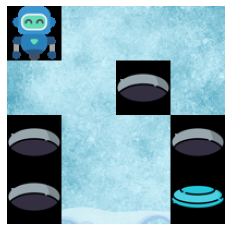

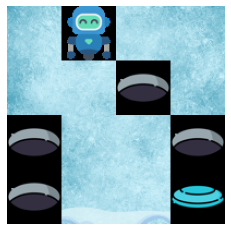

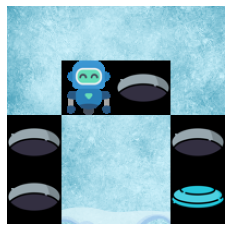

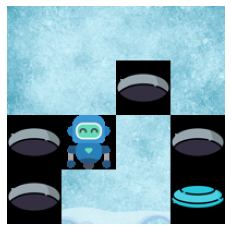

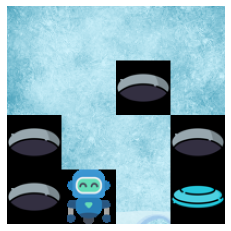

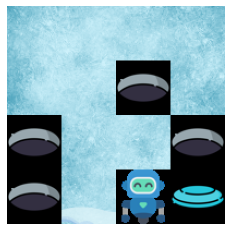

shortest path: 5
longest path: 475
the shortest route is shown in red


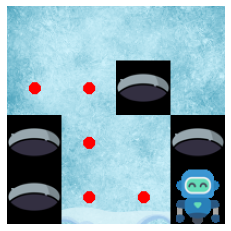

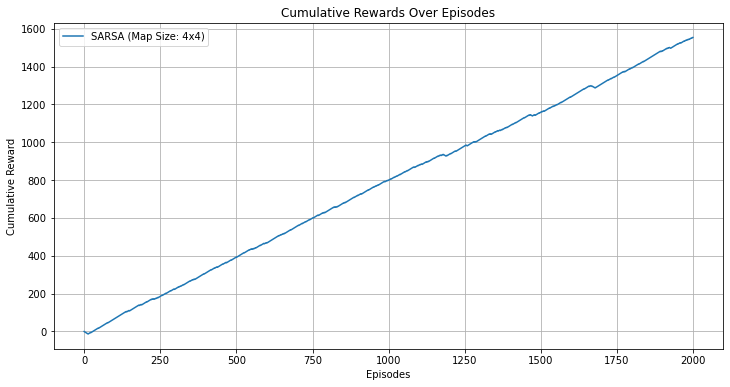

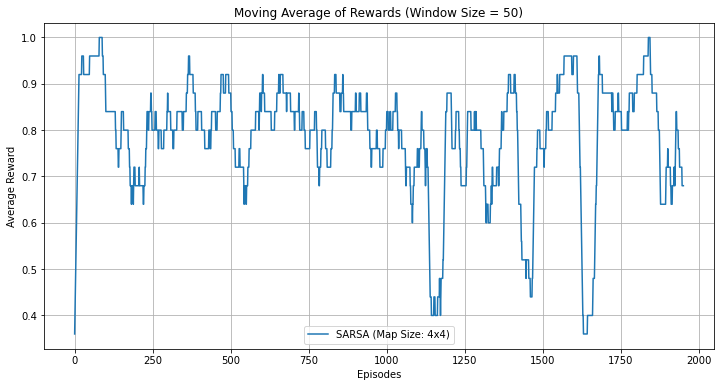

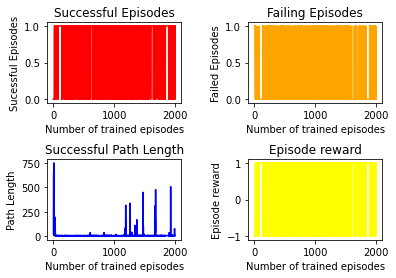

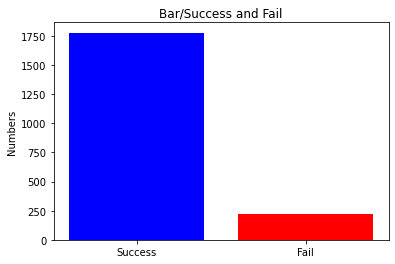

In [5]:
print("Training with SARSA...")
sarsa_agent = SARSA(env)
Q_sarsa, sarsa_rewards = sarsa_agent.train(EPISODES)
print("Training complete!")

# save the Q-table
sarsa_agent.save_q_table_text('q_table_sarsa_4x4.txt')
print("Q-table saved to 'q_table_sarsa_4x4.txt'")

# load the Q-table (optional, if want to test without retraining)
sarsa_agent.load_q_table_text('q_table_sarsa_4x4.txt')
print("Q-table loaded from 'q_table_sarsa_4x4.txt'")

# # visualize the policy 
sarsa_agent.visualize_policy(Q_sarsa, env)  
# # test the policy
sarsa_agent.test_policy(Q_sarsa, env)
# # visualize the value function
sarsa_agent.visualize_value_function(Q_sarsa, env)
# # render the policy
sarsa_agent.render_policy(Q_sarsa, env)

# plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(sarsa_rewards), label=f"SARSA (Map Size: {GRID_SIZE}x{GRID_SIZE})")
plt.title("Cumulative Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid()
plt.show()

# Plot moving average of rewards
window_size = 50  # Moving average window
plt.figure(figsize=(12, 6))
plt.plot(np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid'),
         label=f"SARSA (Map Size: {GRID_SIZE}x{GRID_SIZE})")
plt.title(f"Moving Average of Rewards (Window Size = {window_size})")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.show()

# Collect data for plotting
record_goal = sarsa_agent.record_goal
record_fail = sarsa_agent.record_fail
record_path_length = sarsa_agent.record_path_length
reward_list = sarsa_rewards
performance_bar = [sum(record_goal), sum(record_fail)]

# Call the plot_results function
plot_results(record_goal, record_fail, record_path_length, sarsa_rewards, performance_bar)

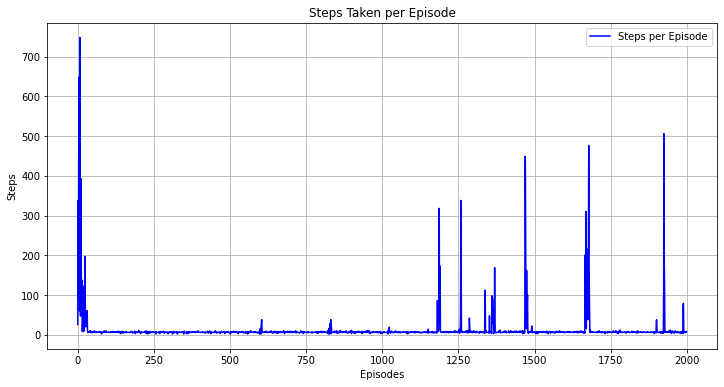

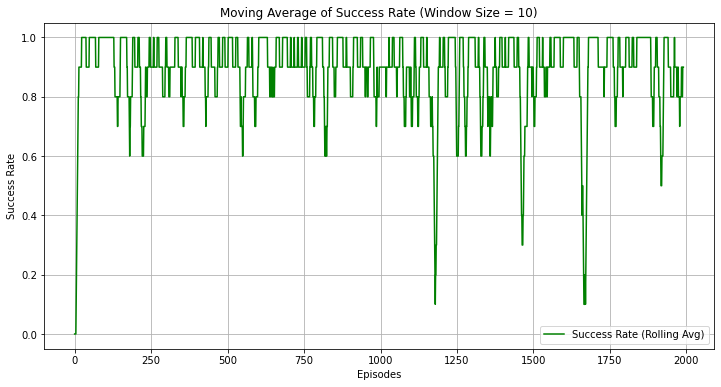

Final Success Rate: 88.85%


In [7]:
# Plot Steps per Episode
plt.figure(figsize=(12, 6))
plt.plot(record_path_length, label="Steps per Episode", color="blue")
plt.title("Steps Taken per Episode")
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.legend()
plt.grid()
plt.show()

# Plot Success Rate (Rolling Average)
window_size = 10  # Rolling window to smooth success rate
rolling_success = np.convolve(record_goal, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(rolling_success, label="Success Rate (Rolling Avg)", color="green")
plt.title("Moving Average of Success Rate (Window Size = 10)")
plt.xlabel("Episodes")
plt.ylabel("Success Rate")
plt.legend()
plt.grid()
plt.show()


final_success_rate = sum(sarsa_agent.record_goal) / len(sarsa_agent.record_goal) * 100
print(f"Final Success Rate: {final_success_rate:.2f}%")